In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
data=pd.read_csv("DS.csv")
data.head(1)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314


In [16]:
data['Length_of_Restaurent'] = data['Restaurant Name'].apply(lambda x: len(str(x)))
data['Length_of_Address'] = data['Address'].apply(lambda x: len(str(x)))
for col in ['Has Table booking', 'Has Online delivery']:
    data[col.replace(' ', '_')] = data[col].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
data['Aggregate rating'] = pd.to_numeric(data['Aggregate rating'], errors='coerce')
data = data.dropna(subset=['Aggregate rating'])
# Choosing  relevant features for the regression model
features = ['Length_of_Restaurent', 'Length_of_Address', 'Has_Table_booking', 'Has_Online_delivery', 'Price range', 'Votes']
# Dropping the nan/null valued once being not to infect
data = data.dropna(subset=features)

X = data[features]
Y = data['Aggregate rating']

In [17]:
#Splitting the data into test,training 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    mse = mean_squared_error(Y_test, preds)
    r2 = r2_score(Y_test, preds)
    print(f"{name}: MSE = {mse:.3f}, R2 = {r2:.3f}")


Linear Regression: MSE = 1.678, R2 = 0.263
Decision Tree: MSE = 0.232, R2 = 0.898
Random Forest: MSE = 0.125, R2 = 0.945


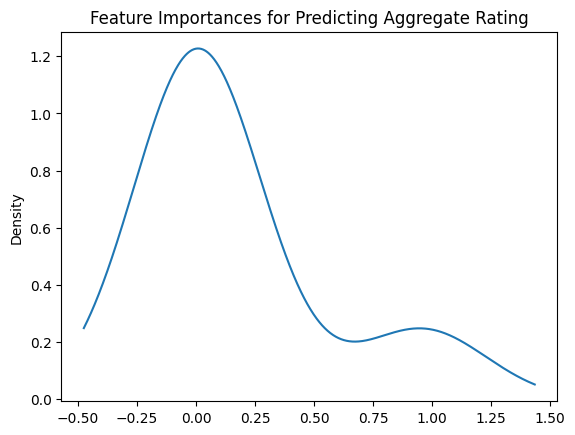

In [22]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='kde')
plt.title('Feature Importances for Predicting Aggregate Rating')
plt.show()


In [29]:
data['Votes'] = pd.to_numeric(data['Votes'], errors='coerce')
data = data.dropna(subset=['Aggregate rating', 'Cuisines'])

# Select top  common individual cuisines for modeling as features inorder to ensure the models performance
from collections import Counter

# Splitting and flattening all the  cuisines
cuisines_all = data['Cuisines'].dropna().str.split(',').sum()
cuisines_flat = [c.strip() for c in cuisines_all]
top_cuisines = [v[0] for v in Counter(cuisines_flat).most_common(10)]  # Top 10

# Create binary indicator columns for top cuisines
for cuisine in top_cuisines:
    data[f'is_{cuisine.replace(" ", "_")}'] = data['Cuisines'].apply(lambda x: 1 if cuisine in str(x) else 0)

features = ['Votes'] + [f'is_{c.replace(" ", "_")}' for c in top_cuisines]
X = data[features]
y = data['Aggregate rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.3f}")
print(f"Test R2 Score: {r2:.3f}")

Test MSE: 0.144
Test R2 Score: 0.937


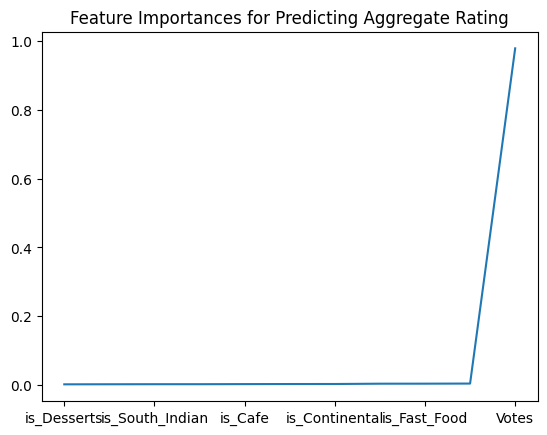

In [63]:
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='line')
plt.Figure(figsize=(2,2))
plt.title('Feature Importances for Predicting Aggregate Rating')
plt.show()


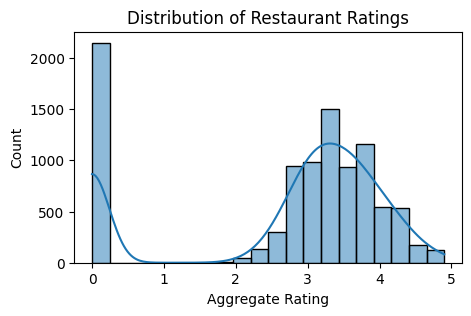

In [64]:
import seaborn as sns
plt.figure(figsize=(5,3))
sns.histplot(data['Aggregate rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Aggregate Rating')
plt.ylabel('Count')
plt.show()

C:\Users\Eswar\AppData\Local\Temp\ipykernel_13236\1130357874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_city.values, y=avg_rating_city.index, palette='Blues_d')


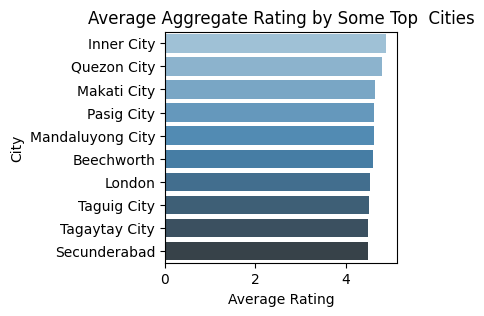

In [65]:
avg_rating_city = data.groupby('City')['Aggregate rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(3,3))
sns.barplot(x=avg_rating_city.values, y=avg_rating_city.index, palette='Blues_d')
plt.title('Average Aggregate Rating by Some Top  Cities')
plt.xlabel('Average Rating')
plt.ylabel('City')
plt.show()


C:\Users\Eswar\AppData\Local\Temp\ipykernel_13236\3337168183.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_cuisine.values, y=avg_rating_cuisine.index, palette='Greens_d')


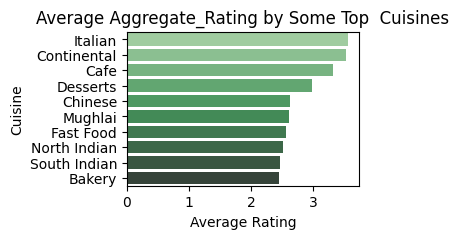

In [66]:
cuisines_all = data['Cuisines'].dropna().str.split(',').sum()
cuisines_flat = [c.strip() for c in cuisines_all]
top_cuisines = [v[0] for v in Counter(cuisines_flat).most_common(10)]
rows = []
for idx, row in data[['Cuisines', 'Aggregate rating']].dropna().iterrows():
    for cuisine in str(row['Cuisines']).split(','):
        c = cuisine.strip()
        if c in top_cuisines:
            rows.append({'Cuisine': c, 'Aggregate rating': row['Aggregate rating']})
cuisine_df = pd.DataFrame(rows)

avg_rating_cuisine = cuisine_df.groupby('Cuisine')['Aggregate rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(3,2))
sns.barplot(x=avg_rating_cuisine.values, y=avg_rating_cuisine.index, palette='Greens_d')
plt.title('Average Aggregate_Rating by Some Top  Cuisines')
plt.xlabel('Average Rating')
plt.ylabel('Cuisine')
plt.show()

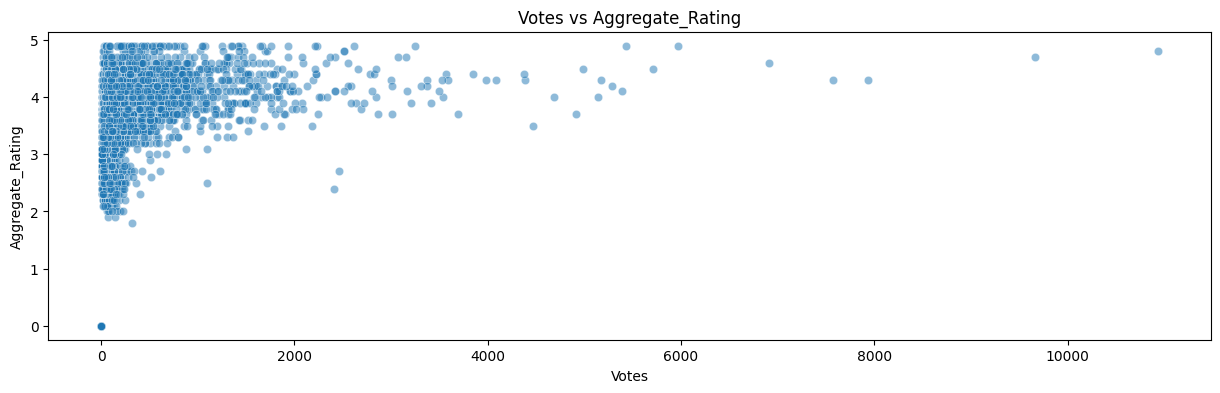

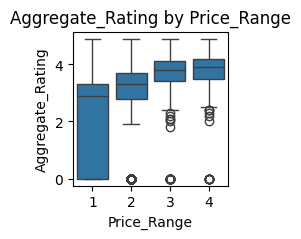

In [67]:
plt.figure(figsize=(15,4))
sns.scatterplot(x='Votes', y='Aggregate rating', data=data, alpha=0.5)
plt.title('Votes vs Aggregate_Rating')
plt.xlabel('Votes')
plt.ylabel('Aggregate_Rating')
plt.show()
plt.figure(figsize=(2,2))
sns.boxplot(x='Price range', y='Aggregate rating', data=data)
plt.title('Aggregate_Rating by Price_Range')
plt.xlabel('Price_Range')
plt.ylabel('Aggregate_Rating')
plt.show()
